[ 성별 분류 예측 모델 ] <hr>

- 다양한 성별과 국가의 남성/여성 이미지 데이터셋 CSV 
- 사전 학습된 AlexNet 모델 사용

< 모듈 및 데이터 로딩 > <hr>

In [1]:
# [1-1] 모듈 로딩
import torch                         # PyTorch: 딥러닝 프레임워크
import torch.nn as nn                # PyTorch: 신경망 관련 모듈
import torch.nn.functional as F      # PyTorch: 유용한 함수 (활성화 함수 등)

from torchvision.datasets import ImageFolder      # PyTorch: 이미지 데이터셋을 폴더 구조로 생성
from torch.utils.data import DataLoader           # PyTorch: 데이터셋을 배치로 로딩하기 위한 클래스
from torchvision.transforms import transforms     # PyTorch: 이미지 전처리 및 데이터 증강을 위한 클래스/함수  

import matplotlib.pyplot as plt                   # Matplotlib: 데이터 및 결과 시각화
import koreanize_matplotlib                       # Matplotlib: 한글 폰트 설정 및 한글화 모듈

from collections import Counter                   # Python 내장 라이브러리: 요소 비율 계산 (데이터 분석용)

from sklearn.model_selection import train_test_split            # Scikit-learn: 데이터셋을 학습/테스트셋으로 분리하는 함수
from torch.utils.data import DataLoader, TensorDataset, Subset  # PyTorch: 데이터로딩 및 데이터셋 관련 클래스/함수
from sklearn.model_selection import train_test_split            # Scikit-learn: 학습/테스트셋 분리 반복 필요 시 재호출 가능

from torchinfo import summary                   # PyTorch: 모델 정보 요약 및 가시화
import torch.optim as optim                     # PyTorch: 최적화 알고리즘 관련 클래스

from torch.utils.data import Dataset, DataLoader               # PyTorch: 데이터셋 정의 및 배치 로더 관련 클래스
import torchmetrics.functional as mt                           # PyTorch Metrics: 함수형 모듈 (정확도 등)
from torchmetrics.classification import *                      # PyTorch Metrics: 분류 관련 메트릭스 클래스 및 함수

from torchmetrics.classification import BinaryAccuracy         # PyTorch Metrics: 이진 분류 정확도 계산 클래스

from torch.optim.lr_scheduler import ReduceLROnPlateau         # PyTorch: 학습률 감소 스케줄링 클래스

from PIL import Image               # Python Imaging Library: 이미지 파일 로드 및 처리

import pandas as pd                 # Pandas: 데이터프레임 생성 및 데이터 분석
import numpy as np                  # Numpy: 수치 데이터 처리 및 배열 계산

from sklearn.preprocessing import LabelEncoder   # Scikit-learn: 문자열로 된 라벨을 숫자로 변환하는 인코더 클래스


c:\Users\knudc\anaconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# [1-2] 데이터 로딩
gender_df = pd.read_csv('exceptbaby.csv')

In [3]:
# [1-3] 데이터 확인
display(gender_df)

,age,ethnicity,gender,pixels
0,10,0,0,30 38 50 90 109 113 126 130 136 139 147 149 15...
1,10,0,0,72 81 94 96 77 85 90 71 76 90 87 80 91 103 118...
2,10,0,0,255 253 252 221 144 174 165 151 151 186 185 14...
3,10,0,0,62 53 55 62 73 74 86 94 106 121 139 161 170 15...
4,10,0,0,28 60 55 55 74 74 62 101 147 140 166 147 161 1...
...,...,...,...,...
22577,99,0,1,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
22578,99,1,1,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
22579,99,2,1,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
22580,99,2,1,45 108 120 156 206 197 140 180 191 199 204 207...


In [4]:
# [1-4] pixel 열 리스트화 
gender_df['pixels']=gender_df['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))

In [5]:
print(type(gender_df['pixels'].iloc[0])) 

<class 'numpy.ndarray'>


In [6]:
display(gender_df)

,age,ethnicity,gender,pixels
0,10,0,0,"[30.0, 38.0, 50.0, 90.0, 109.0, 113.0, 126.0, ..."
1,10,0,0,"[72.0, 81.0, 94.0, 96.0, 77.0, 85.0, 90.0, 71...."
2,10,0,0,"[255.0, 253.0, 252.0, 221.0, 144.0, 174.0, 165..."
3,10,0,0,"[62.0, 53.0, 55.0, 62.0, 73.0, 74.0, 86.0, 94...."
4,10,0,0,"[28.0, 60.0, 55.0, 55.0, 74.0, 74.0, 62.0, 101..."
...,...,...,...,...
22577,99,0,1,"[127.0, 100.0, 94.0, 81.0, 77.0, 77.0, 74.0, 9..."
22578,99,1,1,"[23.0, 28.0, 32.0, 35.0, 42.0, 47.0, 68.0, 85...."
22579,99,2,1,"[59.0, 50.0, 37.0, 40.0, 34.0, 19.0, 30.0, 101..."
22580,99,2,1,"[45.0, 108.0, 120.0, 156.0, 206.0, 197.0, 140...."


In [7]:
import ast  # 안전하게 문자열을 리스트로 변환
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # AlexNet 입력 크기
    transforms.ToTensor(),          # PIL → Tensor (C x H x W)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 기준 정규화
                         std=[0.229, 0.224, 0.225])
])

def preprocess_image_from_array(flat_image):
    image_np = np.array(flat_image, dtype=np.float32)

    try:
        image_np = image_np.reshape((48, 48))  # 1채널 흑백 이미지
    except:
        raise ValueError(f"reshape 실패: 길이={len(flat_image)}")

    # 흑백 이미지를 RGB로 변환
    image_pil = Image.fromarray((image_np * 255).astype(np.uint8)).convert("RGB")

    # 전처리 적용
    image_tensor = transform(image_pil)
    return image_tensor

# 적용
gender_df["processed_image"] = gender_df["pixels"].apply(preprocess_image_from_array)



gender
0    11746
1    10836
Name: count, dtype: int64


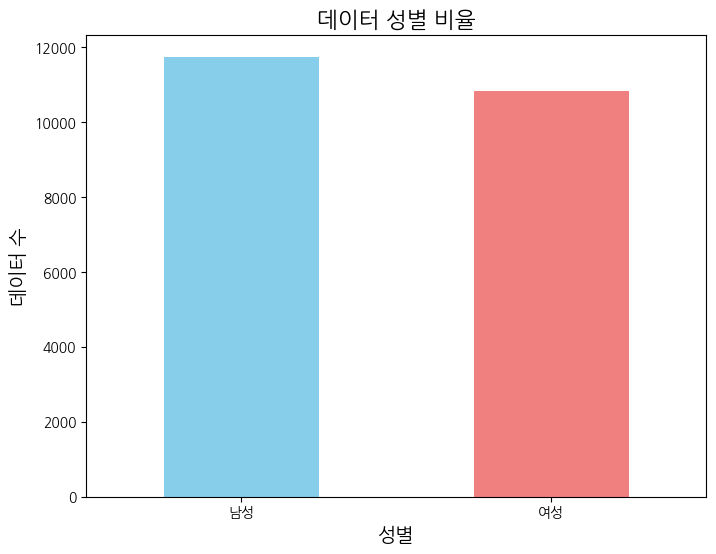

In [ ]:
# [1-5] 데이터 불균형 확인

print(gender_df['gender'].value_counts())

# gender 컬럼의 value_counts 결과
gender_counts = gender_df['gender'].value_counts()

# 시각화
plt.figure(figsize=(8, 6))
gender_counts.plot(kind='bar', color=['skyblue', 'lightcoral']) 
plt.title('데이터 성별 비율', fontsize=16)
plt.xlabel('성별', fontsize=14)
plt.ylabel('데이터 수', fontsize=14)
plt.xticks(rotation=0)
plt.xticks(ticks=[0, 1], labels=['남성', '여성']) # x축 라벨을 숫자 대신 의미로 표시
plt.show()

In [9]:
# [1-6] 결측치 확인 : 없음
print(gender_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22582 entries, 0 to 22581
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              22582 non-null  int64 
 1   ethnicity        22582 non-null  int64 
 2   gender           22582 non-null  int64 
 3   pixels           22582 non-null  object
 4   processed_image  22582 non-null  object
dtypes: int64(3), object(2)
memory usage: 882.2+ KB
None


In [10]:
print(gender_df['processed_image'].head(5))

0    [[[tensor(1.7523), tensor(1.7523), tensor(1.75...
1    [[[tensor(1.0331), tensor(1.0331), tensor(1.03...
2    [[[tensor(-2.1008), tensor(-2.1008), tensor(-2...
3    [[[tensor(1.2043), tensor(1.2043), tensor(1.20...
4    [[[tensor(1.7865), tensor(1.7865), tensor(1.76...
Name: processed_image, dtype: object


< 사전 학습된 AlexNet 모델 > <hr>

In [11]:
import torch
import torch.nn as nn                          # 인공신경망 관련
import torch.nn.functional as F                # 인공신경망 함수들 관련

from torchvision.models import alexnet, AlexNet_Weights
from torchinfo import summary
import torchvision.datasets as datasets
import torchvision.transforms as transforms    # 이미지 전처리 변형 관련
from torch.utils.data import DataLoader   
from torch.utils.data import Subset, random_split
from torchvision.datasets import ImageFolder     

import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib

import os

from sklearn.model_selection import train_test_split 
import torch.optim as optim                                    # PyTorch: 최적화 알고리즘 관련 클래스
from torch.utils.data import Dataset, DataLoader 
import torchmetrics.functional as mt                           # PyTorch Metrics: 함수형 모듈 (정확도 등)
from torchmetrics.classification import *                      # PyTorch Metrics: 분류 관련 메트릭스 클래스 및 함수
from torch.optim.lr_scheduler import ReduceLROnPlateau         # PyTorch: 학습률 감소 스케줄링 클래스

In [12]:
# (1) 사전 학습된 모델 인스턴스 로딩
model = alexnet(weights=AlexNet_Weights.DEFAULT)

# 원래 모델
summary(model, input_size = (1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [1, 1000]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 55, 55]           23,296
│    └─ReLU: 2-2                         [1, 64, 55, 55]           --
│    └─MaxPool2d: 2-3                    [1, 64, 27, 27]           --
│    └─Conv2d: 2-4                       [1, 192, 27, 27]          307,392
│    └─ReLU: 2-5                         [1, 192, 27, 27]          --
│    └─MaxPool2d: 2-6                    [1, 192, 13, 13]          --
│    └─Conv2d: 2-7                       [1, 384, 13, 13]          663,936
│    └─ReLU: 2-8                         [1, 384, 13, 13]          --
│    └─Conv2d: 2-9                       [1, 256, 13, 13]          884,992
│    └─ReLU: 2-10                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-11                      [1, 256, 13, 13]         

In [13]:
# (2) 모델 층별 W,b 파라미터 업데이트 설정 
# features 부분 (requires_grad = False)
# classifier 부분 (requires_grad = True)
for name, param in model.named_parameters():
    
    if name.startswith('features'):
        param.requires_grad=False
    print(name, param.shape, param.requires_grad)

features.0.weight torch.Size([64, 3, 11, 11]) False
features.0.bias torch.Size([64]) False
features.3.weight torch.Size([192, 64, 5, 5]) False
features.3.bias torch.Size([192]) False
features.6.weight torch.Size([384, 192, 3, 3]) False
features.6.bias torch.Size([384]) False
features.8.weight torch.Size([256, 384, 3, 3]) False
features.8.bias torch.Size([256]) False
features.10.weight torch.Size([256, 256, 3, 3]) False
features.10.bias torch.Size([256]) False
classifier.1.weight torch.Size([4096, 9216]) True
classifier.1.bias torch.Size([4096]) True
classifier.4.weight torch.Size([4096, 4096]) True
classifier.4.bias torch.Size([4096]) True
classifier.6.weight torch.Size([1000, 4096]) True
classifier.6.bias torch.Size([1000]) True


In [14]:
# (3) 분류기 부분 변경 => 6번 분류기를 4096,2로 설정함 
model.classifier[6] = nn.Linear(4096, 2)

< 피쳐와 타겟 분리> <hr>

In [15]:
import torch
from torch.utils.data import TensorDataset

# 이미지 텐서 리스트를 하나의 텐서로 묶기
X = torch.stack(gender_df["processed_image"].tolist())  # (N, 3, 224, 224)

# 라벨을 텐서로 변환
y = torch.tensor(gender_df["gender"].tolist(), dtype=torch.long)  # 성별이 정수형으로 되어 있어야 함

# 데이터셋 생성
dataset = TensorDataset(X, y)


In [16]:
# 전체 데이터 수 출력
print('[전체 데이터 수 체크]', len(dataset))

# 인덱스 기반으로 라벨 추출
all_targets = y.tolist()

# (1) 학습/검증 분할
train_indices, valid_indices = train_test_split(
    range(len(all_targets)),
    test_size=0.2,
    random_state=42,
    stratify=all_targets
)

# (2) 검증/테스트 분할
valid_targets = [all_targets[i] for i in valid_indices]
valid_indices, test_indices = train_test_split(
    valid_indices,
    test_size=0.5,
    random_state=42,
    stratify=valid_targets
)

# (3) Subset 구성
trainDS = Subset(dataset, train_indices)
validDS = Subset(dataset, valid_indices)
testDS  = Subset(dataset, test_indices)

# (4) 클래스 비율 확인
for kind, subset in zip(['Train', 'Valid', 'Test'], [trainDS, validDS, testDS]):
    indices = subset.indices
    labels = [all_targets[i] for i in indices]
    count_0 = labels.count(0)
    count_1 = labels.count(1)
    print(f'\n[{kind} 전체 데이터셋 개수 : {len(labels)}개]')
    print(f'        - class 0 개수 : {count_0:02}개 ({count_0/len(labels)*100:.2f}%)')
    print(f'        - class 1 개수 : {count_1:02}개 ({count_1/len(labels)*100:.2f}%)')

[전체 데이터 수 체크] 22582

[Train 전체 데이터셋 개수 : 18065개]
        - class 0 개수 : 9396개 (52.01%)
        - class 1 개수 : 8669개 (47.99%)

[Valid 전체 데이터셋 개수 : 2258개]
        - class 0 개수 : 1175개 (52.04%)
        - class 1 개수 : 1083개 (47.96%)

[Test 전체 데이터셋 개수 : 2259개]
        - class 0 개수 : 1175개 (52.01%)
        - class 1 개수 : 1084개 (47.99%)


In [17]:
## - 훈련용/검증용/테스트용 데이터 로더 생성
trainDL = DataLoader(trainDS, 
                     shuffle=True, 
                     generator=torch.Generator().manual_seed(42))
validDL = DataLoader(validDS, shuffle=False)
testDL  = DataLoader(testDS,  shuffle=False)

< 학습 진행 >  <hr>

In [18]:
# 학습 관련 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)    # to(device) : 모델과 데이터를 지정한 장치로 옮기는 작업 수행 
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
epoch = 5
BATCH_SIZE = 4

In [19]:
# 학습 
for epoch in range(epoch):
    cost = 0.0
    
    for images,classes in trainDL:
        images = images.to(device)
        classes = classes.to(device)
        
        output = model(images)
        loss = criterion(output,classes)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cost += loss
        
    cost = cost / len(trainDL)
    print(f'Epoch : {epoch+1:4d}, Cost : {cost:.3f}')

Epoch :    1, Cost : 0.447
Epoch :    2, Cost : 0.345
Epoch :    3, Cost : 0.313
Epoch :    4, Cost : 0.290
Epoch :    5, Cost : 0.272


In [20]:
# 검증 
with torch.no_grad():
    model.eval()
    
    accuracy = 0.0
    for images, classes in validDL:
        images = images.to(device)
        classes = classes.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=-1)
        outputs_classes = torch.argmax(probs, dim=-1)
        
        accuracy += int(torch.eq(classes, outputs_classes).sum())
        print(f'acc@1 : {accuracy / (len(validDL)*BATCH_SIZE)*100:.2f}%')
        
torch.save(model.state_dict(), './models/alexnet.pt')
print( "Saved the model weights" )

acc@1 : 0.01%
acc@1 : 0.02%
acc@1 : 0.03%
acc@1 : 0.04%
acc@1 : 0.06%
acc@1 : 0.07%
acc@1 : 0.08%
acc@1 : 0.09%
acc@1 : 0.10%
acc@1 : 0.11%
acc@1 : 0.12%
acc@1 : 0.13%
acc@1 : 0.14%
acc@1 : 0.16%
acc@1 : 0.17%
acc@1 : 0.18%
acc@1 : 0.19%
acc@1 : 0.20%
acc@1 : 0.21%
acc@1 : 0.22%
acc@1 : 0.23%
acc@1 : 0.24%
acc@1 : 0.25%
acc@1 : 0.27%
acc@1 : 0.28%
acc@1 : 0.28%
acc@1 : 0.29%
acc@1 : 0.30%
acc@1 : 0.31%
acc@1 : 0.32%
acc@1 : 0.33%
acc@1 : 0.34%
acc@1 : 0.35%
acc@1 : 0.37%
acc@1 : 0.38%
acc@1 : 0.39%
acc@1 : 0.40%
acc@1 : 0.41%
acc@1 : 0.42%
acc@1 : 0.43%
acc@1 : 0.43%
acc@1 : 0.44%
acc@1 : 0.45%
acc@1 : 0.47%
acc@1 : 0.48%
acc@1 : 0.49%
acc@1 : 0.49%
acc@1 : 0.50%
acc@1 : 0.51%
acc@1 : 0.52%
acc@1 : 0.53%
acc@1 : 0.54%
acc@1 : 0.55%
acc@1 : 0.56%
acc@1 : 0.58%
acc@1 : 0.59%
acc@1 : 0.60%
acc@1 : 0.61%
acc@1 : 0.62%
acc@1 : 0.63%
acc@1 : 0.64%
acc@1 : 0.65%
acc@1 : 0.66%
acc@1 : 0.68%
acc@1 : 0.69%
acc@1 : 0.70%
acc@1 : 0.71%
acc@1 : 0.72%
acc@1 : 0.73%
acc@1 : 0.74%
acc@1 : 0.75%
acc@1 